<ipython-input-13-f1bc22ef7602>:22: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Polygon':


Total cycles found: 357104
Circular/Oval cycles detected: 1078


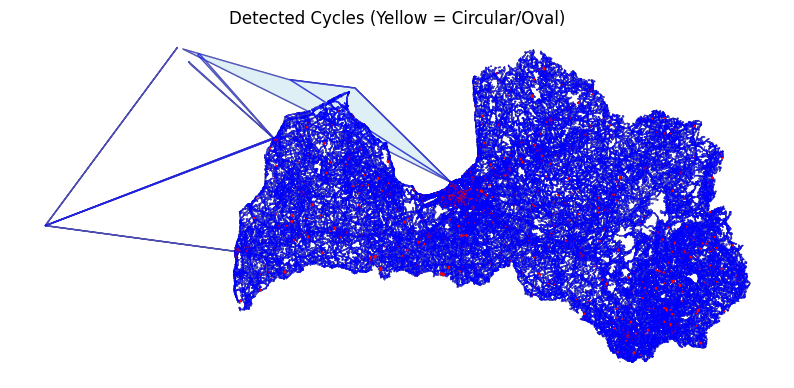

In [13]:
# Install required packages
!pip install geopandas shapely networkx matplotlib fiona pyproj --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, Polygon, LineString
from shapely.ops import unary_union, polygonize
import matplotlib.pyplot as plt
import fiona
import math

# === 1. Load polygon geometries (only geometry, skip attributes) ===
with fiona.open("polygon.shp") as src:  # replace with your shapefile
    geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs)

# === 2. Convert polygon edges to line segments ===
edges = []
for geom in gdf.geometry:
    if geom.type == 'Polygon':
        for ring in [geom.exterior] + list(geom.interiors):
            coords = list(ring.coords)
            edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]

# === 3. Build a graph from the line segments ===
G = nx.Graph()
for line in edges:
    coords = list(line.coords)
    G.add_edge(coords[0], coords[1], geometry=line)

# === 4. Extract cycles (rings) from the line graph ===
merged = unary_union(list(nx.get_edge_attributes(G, 'geometry').values()))
polygons_from_cycles = list(polygonize(merged))

# === 5. Calculate circularity of each cycle ===
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    if perimeter == 0:
        return 0
    return (4 * math.pi * area) / (perimeter ** 2)

cycle_gdf = gpd.GeoDataFrame(geometry=polygons_from_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# === 6. Filter circular/oval cycles ===
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD].copy()

print(f"Total cycles found: {len(cycle_gdf)}")
print(f"Circular/Oval cycles detected: {len(circular_cycles)}")

# === 7. Plot results ===
base = gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red")
plt.title("Detected Cycles (Yellow = Circular/Oval)")
plt.axis("off")
plt.show()

# === 8. Optional: Save cycles as new shapefile ===
# circular_cycles.to_file("circular_cycles.shp")


In [14]:
circular_cycles.to_file("circular_cycles.geojson", driver="GeoJSON")


Filtered polygons count: 201


<ipython-input-18-ae096dc7ccff>:38: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Polygon':


Total cycles found in selection: 221
Circular/Oval cycles detected in selection: 4


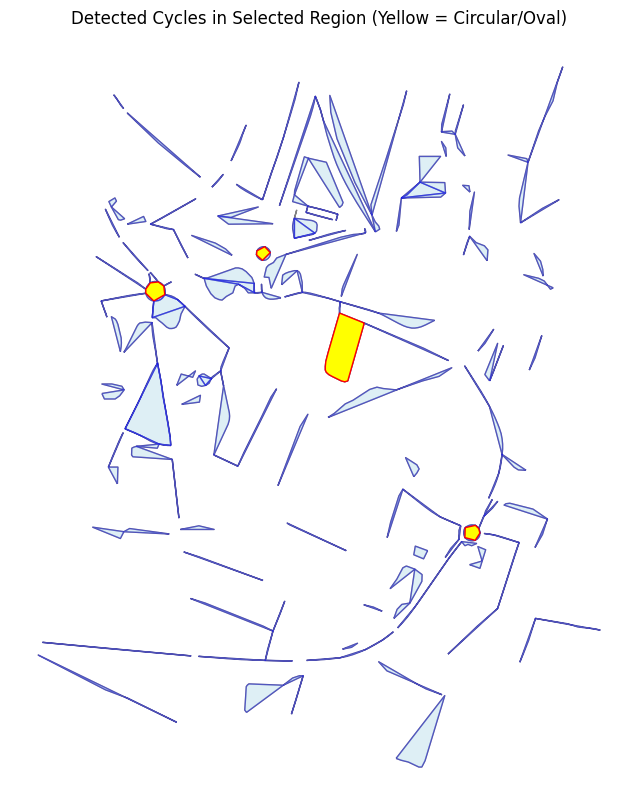

In [18]:
# Install required packages if not installed
!pip install geopandas shapely fiona networkx pyproj --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math

# --- Step 1: Load large polygon shapefile (only geometry) ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Step 2: Load selection polygon(s) ---
selection_gdf = gpd.read_file("select.shp")

# --- Step 3: Ensure both GeoDataFrames use the same CRS ---
if large_gdf.crs != selection_gdf.crs:
    selection_gdf = selection_gdf.to_crs(large_gdf.crs)

# --- Step 4: Filter polygons intersecting the selection area ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons count: {len(filtered_gdf)}")

# --- Helper function: round coordinates to avoid floating point issues ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

# --- Step 5: Extract edges from filtered polygons, supporting MultiPolygons ---
edges = []
for geom in filtered_gdf.geometry:
    polygons = []
    if geom.type == 'Polygon':
        polygons = [geom]
    elif geom.type == 'MultiPolygon':
        polygons = list(geom.geoms)
    else:
        continue  # skip other geometry types

    for polygon in polygons:
        # Exterior ring
        coords = list(polygon.exterior.coords)
        edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]
        # Interior rings (holes)
        for interior in polygon.interiors:
            coords = list(interior.coords)
            edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]

# --- Step 6: Build graph from edges ---
G = nx.Graph()
for line in edges:
    coords = list(line.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=line)

# --- Step 7: Extract cycles (rings) from graph edges ---
merged = unary_union(list(nx.get_edge_attributes(G, 'geometry').values()))
polygons_from_cycles = list(polygonize(merged))

# --- Step 8: Calculate circularity of each cycle ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    if perimeter == 0:
        return 0
    return (4 * math.pi * area) / (perimeter ** 2)

cycle_gdf = gpd.GeoDataFrame(geometry=polygons_from_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Step 9: Filter cycles by circularity threshold ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD].copy()

print(f"Total cycles found in selection: {len(cycle_gdf)}")
print(f"Circular/Oval cycles detected in selection: {len(circular_cycles)}")

# --- Step 10: Plot the results ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red")
plt.title("Detected Cycles in Selected Region (Yellow = Circular/Oval)")
plt.axis("off")
plt.show()

# --- Optional: save circular cycles shapefile ---
circular_cycles.to_file("circular_cycles.geojson", driver="GeoJSON")


Filtered polygons count: 201


<ipython-input-19-4b999ec52649>:39: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Polygon':


Total cycles found in selection: 221
Circular/Oval cycles detected in selection: 4


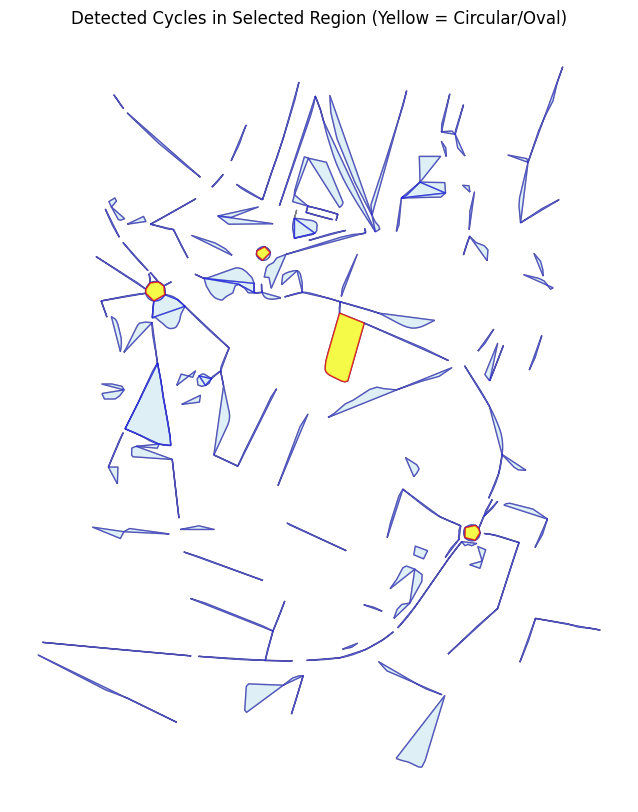

In [19]:
# Install required packages if not installed
!pip install geopandas shapely fiona networkx pyproj matplotlib --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt

# --- Step 1: Load large polygon shapefile (only geometry) ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Step 2: Load selection polygon(s) ---
selection_gdf = gpd.read_file("select.shp")

# --- Step 3: Ensure both GeoDataFrames use the same CRS ---
if large_gdf.crs != selection_gdf.crs:
    selection_gdf = selection_gdf.to_crs(large_gdf.crs)

# --- Step 4: Filter polygons intersecting the selection area ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons count: {len(filtered_gdf)}")

# --- Helper function: round coordinates to avoid floating point issues ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

# --- Step 5: Extract edges from filtered polygons, supporting MultiPolygons ---
edges = []
for geom in filtered_gdf.geometry:
    polygons = []
    if geom.type == 'Polygon':
        polygons = [geom]
    elif geom.type == 'MultiPolygon':
        polygons = list(geom.geoms)
    else:
        continue  # skip other geometry types

    for polygon in polygons:
        # Exterior ring
        coords = list(polygon.exterior.coords)
        edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]
        # Interior rings (holes)
        for interior in polygon.interiors:
            coords = list(interior.coords)
            edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]

# --- Step 6: Build graph from edges ---
G = nx.Graph()
for line in edges:
    coords = list(line.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=line)

# --- Step 7: Extract cycles (rings) from graph edges ---
merged = unary_union(list(nx.get_edge_attributes(G, 'geometry').values()))
polygons_from_cycles = list(polygonize(merged))

# --- Step 8: Calculate circularity of each cycle ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    if perimeter == 0:
        return 0
    return (4 * math.pi * area) / (perimeter ** 2)

cycle_gdf = gpd.GeoDataFrame(geometry=polygons_from_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Step 9: Filter cycles by circularity threshold ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD].copy()

print(f"Total cycles found in selection: {len(cycle_gdf)}")
print(f"Circular/Oval cycles detected in selection: {len(circular_cycles)}")

# --- Step 10: Plot the results ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.7)
plt.title("Detected Cycles in Selected Region (Yellow = Circular/Oval)")
plt.axis("off")
plt.show()

# --- Optional: save circular cycles to GeoJSON ---
circular_cycles.to_file("circular_cycles.geojson", driver="GeoJSON")


Filtered polygons: 201


<ipython-input-21-5ecfcebe15aa>:32: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)


Total cycles detected: 221
Circular cycles detected: 4


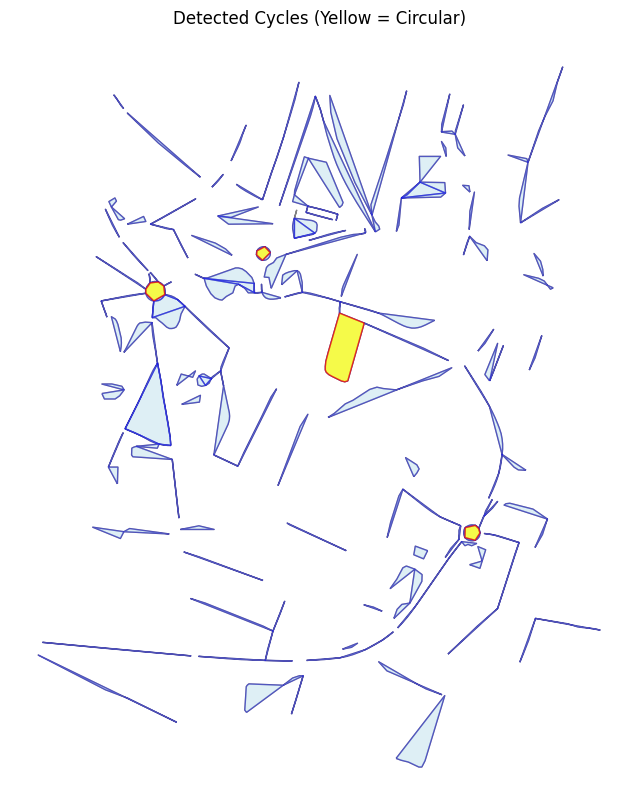

In [21]:
# Install required packages
!pip install geopandas shapely fiona networkx matplotlib --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt

# --- Step 1: Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Step 2: Load selection polygon(s) ---
selection_gdf = gpd.read_file("select.shp")
if selection_gdf.crs != large_gdf.crs:
    selection_gdf = selection_gdf.to_crs(large_gdf.crs)

# --- Step 3: Filter intersecting polygons ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Step 4: Extract edges (from boundaries of filtered polygons) ---
edges = []
for geom in filtered_gdf.geometry:
    polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
    for polygon in polygons:
        coords = list(polygon.exterior.coords)
        edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords)-1)]
        for interior in polygon.interiors:
            icoords = list(interior.coords)
            edges += [LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords)-1)]

# --- Step 5: Build graph from edges ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

G = nx.Graph()
for line in edges:
    coords = list(line.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=line)

# --- Step 6: Polygonize the graph (detect cycles) ---
edge_geometries = list(nx.get_edge_attributes(G, 'geometry').values())
merged_lines = unary_union(edge_geometries)
polygonized_cycles = list(polygonize(merged_lines))  # THESE are your cycles

# --- Step 7: Circularity calculation ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    if perimeter == 0:
        return 0
    return (4 * math.pi * area) / (perimeter ** 2)

cycle_gdf = gpd.GeoDataFrame(geometry=polygonized_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Step 8: Filter circular cycles ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD].copy()

print(f"Total cycles detected: {len(cycle_gdf)}")
print(f"Circular cycles detected: {len(circular_cycles)}")

# --- Step 9: Plot the results ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.7)
plt.title("Detected Cycles (Yellow = Circular)")
plt.axis("off")
plt.show()

# --- Optional: Save circular cycles ---
circular_cycles.to_file("circular_cycles.geojson", driver="GeoJSON")


Filtered polygons: 201


<ipython-input-22-57f916452764>:29: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
<ipython-input-22-57f916452764>:58: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == "Polygon":


Total new cycles: 57
Circular ones: 3


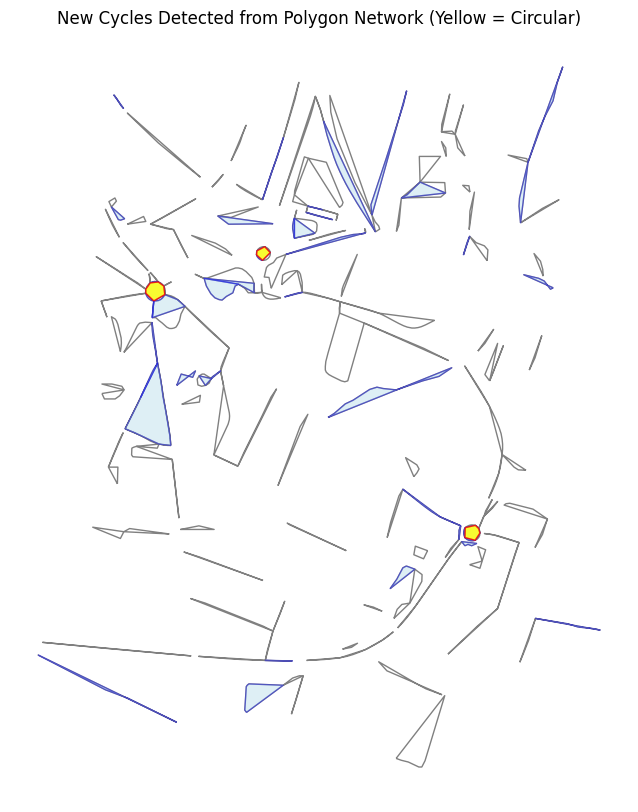

In [22]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Load selection area ---
selection_gdf = gpd.read_file("select.shp")
if selection_gdf.crs != large_gdf.crs:
    selection_gdf = selection_gdf.to_crs(large_gdf.crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Extract edges from all polygons ---
edges = []
for geom in filtered_gdf.geometry:
    polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        # Exterior
        coords = list(poly.exterior.coords)
        edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]
        # Interior (holes)
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges += [LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)]

# --- Build a graph from edges ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

G = nx.Graph()
for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=edge)

# --- Use polygonize to find cycles from all edges ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged = unary_union(edge_geoms)
cycles = list(polygonize(merged))  # All loops formed by edges

# --- Filter out cycles that are duplicates of the input polygons ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.type == "Polygon":
        input_polygons.append(geom)
    elif geom.type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

# Use WKT for fast geometry comparison
input_wkts = set([poly.wkt for poly in input_polygons])
new_cycles = [c for c in cycles if c.wkt not in input_wkts]

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Filter by circularity threshold ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles: {len(cycle_gdf)}")
print(f"Circular ones: {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)
plt.title("New Cycles Detected from Polygon Network (Yellow = Circular)")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("new_circular_cycles.geojson", driver="GeoJSON")


Filtered polygons: 199


<ipython-input-24-f8c24de77efe>:37: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
<ipython-input-24-f8c24de77efe>:66: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == "Polygon":


Total new cycles: 55
Circular ones (circularity ≥ 0.7): 3


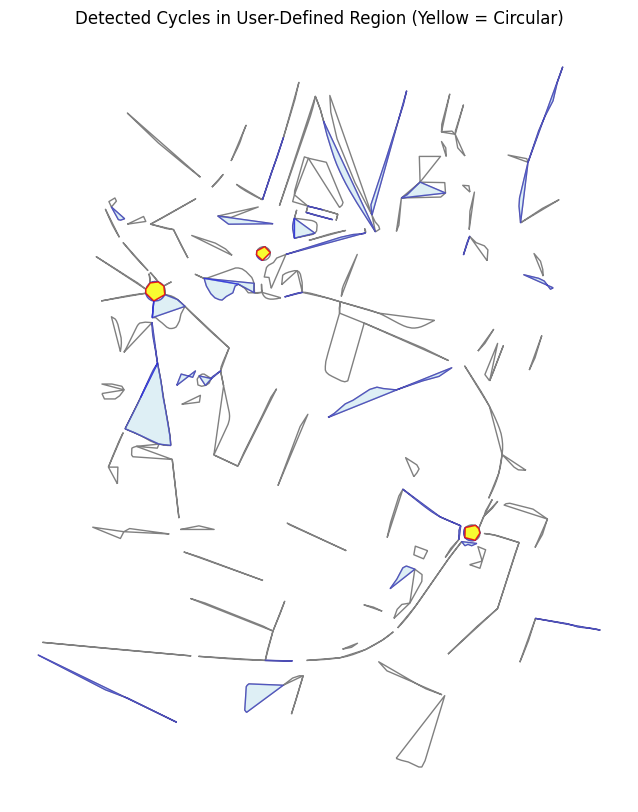

In [24]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
coords = [
    (25.88702, 56.49741),
    (25.88743, 56.48413),
    (25.86992, 56.4843),
    (25.87009, 56.49727)
]
selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Extract edges from polygons ---
edges = []
for geom in filtered_gdf.geometry:
    polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        # Exterior
        coords = list(poly.exterior.coords)
        edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]
        # Interior (holes)
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges += [LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)]

# --- Build a graph from edges ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

G = nx.Graph()
for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=edge)

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged = unary_union(edge_geoms)
cycles = list(polygonize(merged))

# --- Remove original polygons (rings) from the result ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.type == "Polygon":
        input_polygons.append(geom)
    elif geom.type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

input_wkts = set(poly.wkt for poly in input_polygons)
new_cycles = [c for c in cycles if c.wkt not in input_wkts]

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Filter circular cycles ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles: {len(cycle_gdf)}")
print(f"Circular ones (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)
plt.title("Detected Cycles in User-Defined Region (Yellow = Circular)")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("user_defined_circular_cycles.geojson", driver="GeoJSON")


Filtered polygons: 183


<ipython-input-26-7c78959b11a5>:37: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
<ipython-input-26-7c78959b11a5>:66: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == "Polygon":


Total new cycles: 59
Circular ones (circularity ≥ 0.7): 3


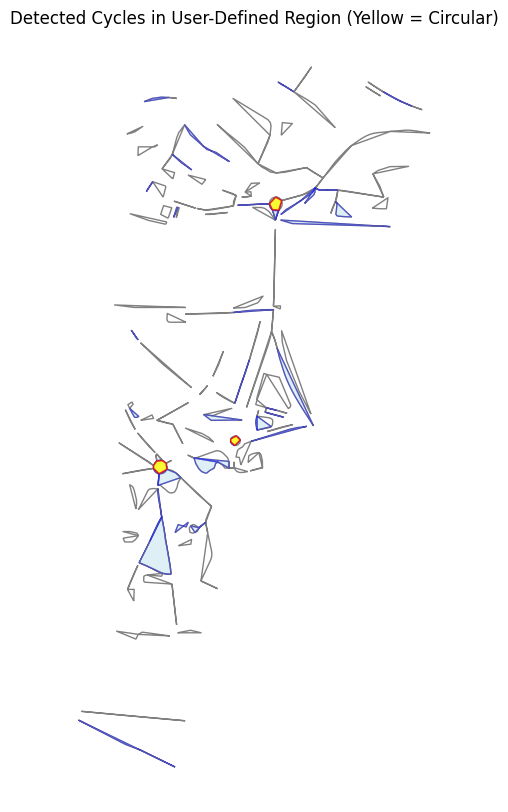

In [26]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
coords = [
    (25.87055, 56.50492),
    (25.88743, 56.50543),
    (25.86992, 56.4843),
    (25.87009, 56.49727)
]
selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Extract edges from polygons ---
edges = []
for geom in filtered_gdf.geometry:
    polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        # Exterior
        coords = list(poly.exterior.coords)
        edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]
        # Interior (holes)
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges += [LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)]

# --- Build a graph from edges ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

G = nx.Graph()
for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=edge)

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged = unary_union(edge_geoms)
cycles = list(polygonize(merged))

# --- Remove original polygons (rings) from the result ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.type == "Polygon":
        input_polygons.append(geom)
    elif geom.type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

input_wkts = set(poly.wkt for poly in input_polygons)
new_cycles = [c for c in cycles if c.wkt not in input_wkts]

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Filter circular cycles ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles: {len(cycle_gdf)}")
print(f"Circular ones (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)
plt.title("Detected Cycles in User-Defined Region (Yellow = Circular)")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("user_defined_circular_cycles.geojson", driver="GeoJSON")


Filtered polygons: 847


<ipython-input-29-62c73202a1e6>:37: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
<ipython-input-29-62c73202a1e6>:66: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == "Polygon":


Total new cycles: 334
Circular ones (circularity ≥ 0.7): 8


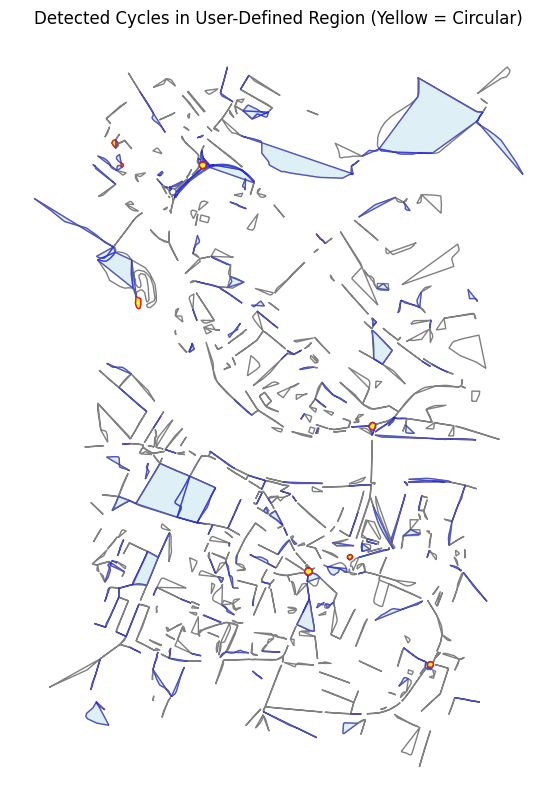

In [29]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
coords = [
    (25.85121, 56.52142),
    (25.89038, 56.52098),
    (25.88738, 56.48394),
    (25.84945, 56.48555)
]
selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Extract edges from polygons ---
edges = []
for geom in filtered_gdf.geometry:
    polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        # Exterior
        coords = list(poly.exterior.coords)
        edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]
        # Interior (holes)
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges += [LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)]

# --- Build a graph from edges ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

G = nx.Graph()
for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=edge)

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged = unary_union(edge_geoms)
cycles = list(polygonize(merged))

# --- Remove original polygons (rings) from the result ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.type == "Polygon":
        input_polygons.append(geom)
    elif geom.type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

input_wkts = set(poly.wkt for poly in input_polygons)
new_cycles = [c for c in cycles if c.wkt not in input_wkts]

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Filter circular cycles ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles: {len(cycle_gdf)}")
print(f"Circular ones (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)
plt.title("Detected Cycles in User-Defined Region (Yellow = Circular)")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("user_defined_circular_cycles1.geojson", driver="GeoJSON")


Filtered polygons: 847
Invalid geometries count before fix: 92
Invalid geometries count after fix: 0


<ipython-input-55-b8c2955b905a>:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
<ipython-input-55-b8c2955b905a>:79: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == "Polygon":
<ipython-input-55-b8c2955b905a>:81: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == "MultiPolygon":


Total new cycles (not input polygons): 32
Circular ones (circularity ≥ 0.7): 5


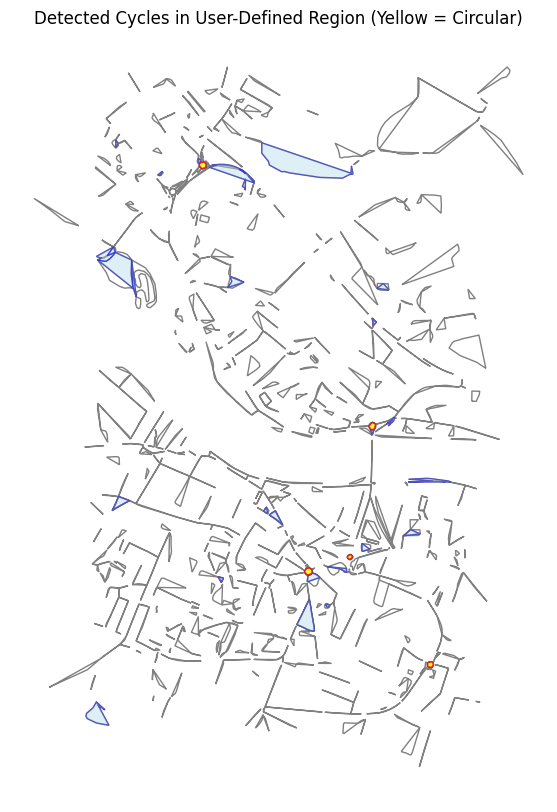

Filtered polygons: 199


<ipython-input-33-cf2d0b7ec2f9>:37: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
<ipython-input-33-cf2d0b7ec2f9>:64: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == "Polygon":


Total new cycles (not input polygons): 29
Circular ones (circularity ≥ 0.7): 3


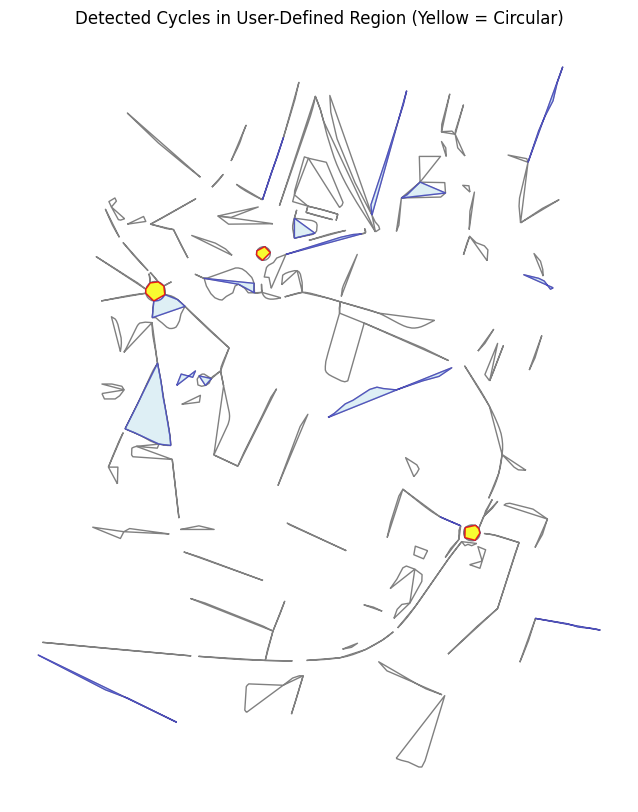

In [33]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
coords = [
    (25.88702, 56.49741),
    (25.88743, 56.48413),
    (25.86992, 56.4843),
    (25.87009, 56.49727)
]
selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Extract edges from polygons ---
edges = []
for geom in filtered_gdf.geometry:
    polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        coords = list(poly.exterior.coords)
        edges += [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges += [LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)]

# --- Build a graph from edges ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

G = nx.Graph()
for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=edge)

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged = unary_union(edge_geoms)
cycles = list(polygonize(merged))

# --- Remove cycles that are part of the input polygons ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.type == "Polygon":
        input_polygons.append(geom)
    elif geom.type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

# Filter cycles that are not exactly part of any original polygon
new_cycles = []
for cycle in cycles:
    if not any(poly.contains(cycle) or poly.equals(cycle) for poly in input_polygons):
        new_cycles.append(cycle)

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Filter circular cycles ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles (not input polygons): {len(cycle_gdf)}")
print(f"Circular ones (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)
plt.title("Detected Cycles in User-Defined Region (Yellow = Circular)")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("user_defined_circular_cycles4.geojson", driver="GeoJSON")


Filtered polygons: 847


<ipython-input-54-df8b03a91e77>:43: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
<ipython-input-54-df8b03a91e77>:75: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == "Polygon":
<ipython-input-54-df8b03a91e77>:77: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == "MultiPolygon":


Total new cycles (not input polygons): 32
Circular ones (circularity ≥ 0.7): 5


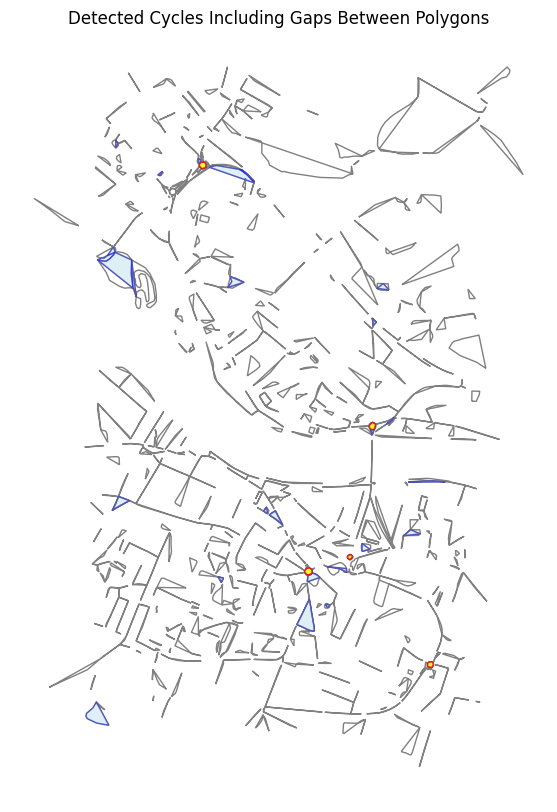

In [54]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
coords = [
    (25.85121, 56.52142),
    (25.89038, 56.52098),
    (25.88738, 56.48394),
    (25.84945, 56.48555)
]
selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Fix invalid geometries ---
invalid_count = filtered_gdf[~filtered_gdf.is_valid].shape[0]
if invalid_count > 0:
    filtered_gdf['geometry'] = filtered_gdf['geometry'].buffer(0)

# --- Extract edges from each polygon individually ---
edges = []

def extract_edges(geom):
    polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        # Exterior ring
        coords = list(poly.exterior.coords)
        edges.extend([LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)])
        # Interior rings
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges.extend([LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)])

for geom in filtered_gdf.geometry:
    extract_edges(geom)

# --- Build graph from edges ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

G = nx.Graph()
for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=edge)

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged_edges = unary_union(edge_geoms)
cycles = list(polygonize(merged_edges))

# --- Remove cycles that are part of the original polygons ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.type == "Polygon":
        input_polygons.append(geom)
    elif geom.type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

# Retain cycles that are not fully contained in original polygons
new_cycles = []
for cycle in cycles:
    if not any(poly.contains(cycle) or poly.equals(cycle) for poly in input_polygons):
        new_cycles.append(cycle)

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Filter circular cycles ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles (not input polygons): {len(cycle_gdf)}")
print(f"Circular ones (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)
plt.title("Detected Cycles Including Gaps Between Polygons")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("user_defined_circular_cycles_final.geojson", driver="GeoJSON")


Filtered polygons: 847


<ipython-input-56-00a2fc2bb935>:46: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
<ipython-input-56-00a2fc2bb935>:104: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == "Polygon":
<ipython-input-56-00a2fc2bb935>:106: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == "MultiPolygon":


Total new cycles (not input polygons): 156
Circular ones (circularity ≥ 0.7): 9


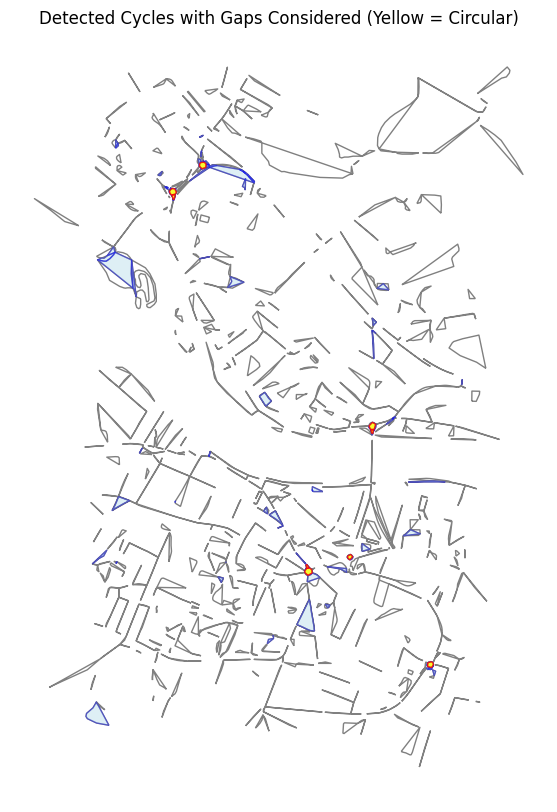

In [56]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib scipy --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy as np

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
coords = [
    (25.85121, 56.52142),
    (25.89038, 56.52098),
    (25.88738, 56.48394),
    (25.84945, 56.48555)
]
selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Fix invalid geometries ---
invalid_count = filtered_gdf[~filtered_gdf.is_valid].shape[0]
if invalid_count > 0:
    filtered_gdf['geometry'] = filtered_gdf['geometry'].buffer(0)

# --- Extract edges from each polygon ---
edges = []

def extract_edges(geom):
    polygons = [geom] if geom.type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        coords = list(poly.exterior.coords)
        edges.extend([LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)])
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges.extend([LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)])

for geom in filtered_gdf.geometry:
    extract_edges(geom)

# --- Build graph with proximity-based linking ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

SNAP_DISTANCE = 0.0001  # Adjust based on your data scale (~10m in degrees)

# Step 1: Collect endpoints and build KDTree
endpoints = []
edge_map = []

for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    endpoints.append(start)
    endpoints.append(end)
    edge_map.append((start, end, edge))

unique_points = list(set(endpoints))
point_array = np.array(unique_points)
tree = cKDTree(point_array)

# Step 2: Proximity pairs
pairs = tree.query_pairs(SNAP_DISTANCE)

# Step 3: Build graph
G = nx.Graph()

# Original edges
for start, end, edge in edge_map:
    G.add_edge(start, end, geometry=edge)

# Extra proximity edges
for i, j in pairs:
    pt1 = tuple(point_array[i])
    pt2 = tuple(point_array[j])
    if not G.has_edge(pt1, pt2):
        G.add_edge(pt1, pt2, geometry=LineString([pt1, pt2]))

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged_edges = unary_union(edge_geoms)
cycles = list(polygonize(merged_edges))

# --- Remove cycles that are part of input polygons ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.type == "Polygon":
        input_polygons.append(geom)
    elif geom.type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

# Keep only cycles that are not equal to or inside input polygons
new_cycles = []
for cycle in cycles:
    if not any(poly.contains(cycle) or poly.equals(cycle) for poly in input_polygons):
        new_cycles.append(cycle)

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Filter circular cycles ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles (not input polygons): {len(cycle_gdf)}")
print(f"Circular ones (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)
circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)
plt.title("Detected Cycles with Gaps Considered (Yellow = Circular)")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("user_defined_circular_cycles_with_gaps.geojson", driver="GeoJSON")


Filtered polygons: 44
Total new cycles (not input polygons): 2
Circular ones (circularity ≥ 0.5): 2


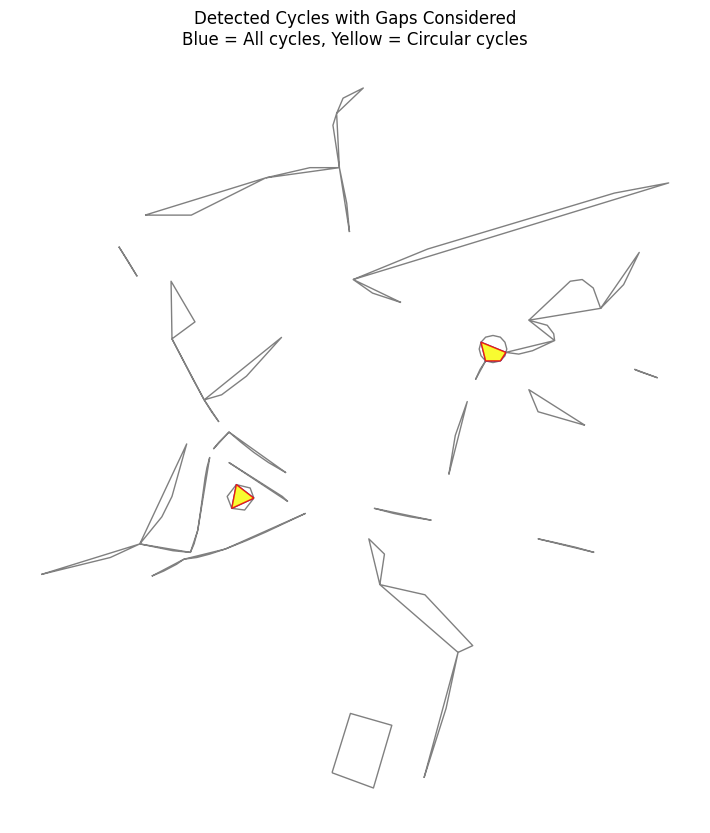

In [69]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
coords = [
    (27.262058, 57.135039),
    (27.26764, 57.135047),
    (27.267681, 57.131038),
    (27.261936, 57.131054)
]
selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Fix invalid geometries ---
invalid_count = filtered_gdf[~filtered_gdf.is_valid].shape[0]
if invalid_count > 0:
    filtered_gdf['geometry'] = filtered_gdf['geometry'].buffer(0)

# --- Extract edges from each polygon individually ---
edges = []

def extract_edges(geom):
    polygons = [geom] if geom.geom_type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        # Exterior ring
        coords = list(poly.exterior.coords)
        edges.extend([LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)])
        # Interior rings
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges.extend([LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)])

for geom in filtered_gdf.geometry:
    extract_edges(geom)

# --- Build graph from edges ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

G = nx.Graph()
for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=edge)

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged_edges = unary_union(edge_geoms)
cycles = list(polygonize(merged_edges))

# --- Remove cycles that are part of the original polygons ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.geom_type == "Polygon":
        input_polygons.append(geom)
    elif geom.geom_type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

# Retain cycles that are not fully contained or equal to original polygons
new_cycles = []
for cycle in cycles:
    if not any(poly.contains(cycle) or poly.equals(cycle) for poly in input_polygons):
        new_cycles.append(cycle)

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Filter circular cycles ---
CIRCULARITY_THRESHOLD = 0.5
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles (not input polygons): {len(cycle_gdf)}")
print(f"Circular ones (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))

# Plot all detected new cycles in light blue
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)

# Highlight circular cycles in yellow with red edges
if not circular_cycles.empty:
    circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)

plt.title("Detected Cycles with Gaps Considered\nBlue = All cycles, Yellow = Circular cycles")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("user_defined_circular_cycles_final2.geojson", driver="GeoJSON")


Filtered polygons: 847
Total new cycles (not input polygons): 32
Circular ones (circularity ≥ 0.7): 5


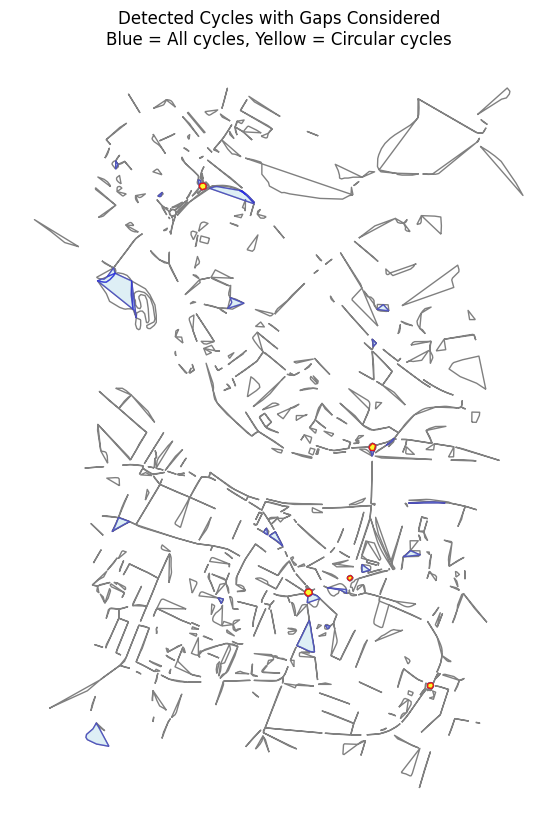

In [74]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
coords = [
    (25.85121, 56.52142),
    (25.89038, 56.52098),
    (25.88738, 56.48394),
    (25.84945, 56.48555)
]
selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Fix invalid geometries ---
invalid_count = filtered_gdf[~filtered_gdf.is_valid].shape[0]
if invalid_count > 0:
    filtered_gdf['geometry'] = filtered_gdf['geometry'].buffer(0)

# --- Extract edges from each polygon individually ---
edges = []

def extract_edges(geom):
    polygons = [geom] if geom.geom_type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        # Exterior ring
        coords = list(poly.exterior.coords)
        edges.extend([LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)])
        # Interior rings
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges.extend([LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)])

for geom in filtered_gdf.geometry:
    extract_edges(geom)

# --- Build graph from edges ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

G = nx.Graph()
for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    G.add_edge(start, end, geometry=edge)

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged_edges = unary_union(edge_geoms)
cycles = list(polygonize(merged_edges))

# --- Remove cycles that are part of the original polygons ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.geom_type == "Polygon":
        input_polygons.append(geom)
    elif geom.geom_type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

# Retain cycles that are not fully contained or equal to original polygons
new_cycles = []
for cycle in cycles:
    if not any(poly.contains(cycle) or poly.equals(cycle) for poly in input_polygons):
        new_cycles.append(cycle)

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Filter circular cycles ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles (not input polygons): {len(cycle_gdf)}")
print(f"Circular ones (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))

# Plot all detected new cycles in light blue
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)

# Highlight circular cycles in yellow with red edges
if not circular_cycles.empty:
    circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)

plt.title("Detected Cycles with Gaps Considered\nBlue = All cycles, Yellow = Circular cycles")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("user_defined_circular_cycles_final3.geojson", driver="GeoJSON")


Filtered polygons: 847
Total new cycles (not input polygons): 156
Circular ones (circularity ≥ 0.7): 9


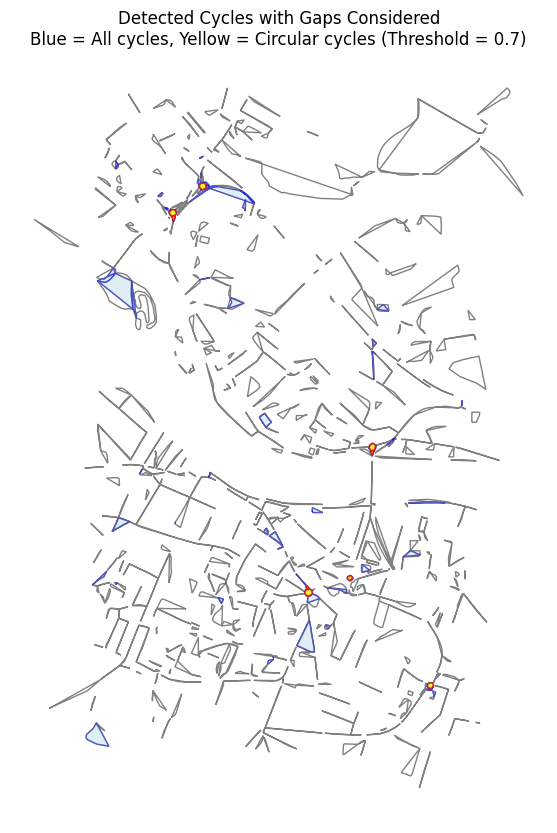

In [78]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib scipy --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
coords = [
    (25.85121, 56.52142),
    (25.89038, 56.52098),
    (25.88738, 56.48394),
    (25.84945, 56.48555)
]
selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Fix invalid geometries ---
invalid_count = filtered_gdf[~filtered_gdf.is_valid].shape[0]
if invalid_count > 0:
    filtered_gdf['geometry'] = filtered_gdf['geometry'].buffer(0)

# --- Extract edges from each polygon ---
edges = []

def extract_edges(geom):
    polygons = [geom] if geom.geom_type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        coords = list(poly.exterior.coords)
        edges.extend([LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)])
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges.extend([LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)])

for geom in filtered_gdf.geometry:
    extract_edges(geom)

# --- Build graph with proximity-based linking ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

SNAP_DISTANCE = 0.0001  # Adjust based on your data scale (~10m in degrees)

# Step 1: Collect endpoints and build KDTree
endpoints = []
edge_map = []

for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    endpoints.append(start)
    endpoints.append(end)
    edge_map.append((start, end, edge))

unique_points = list(set(endpoints))
point_array = np.array(unique_points)
tree = cKDTree(point_array)

# Step 2: Proximity pairs
pairs = tree.query_pairs(SNAP_DISTANCE)

# Step 3: Build graph
G = nx.Graph()

# Original edges
for start, end, edge in edge_map:
    G.add_edge(start, end, geometry=edge)

# Extra proximity edges
for i, j in pairs:
    pt1 = tuple(point_array[i])
    pt2 = tuple(point_array[j])
    if not G.has_edge(pt1, pt2):
        G.add_edge(pt1, pt2, geometry=LineString([pt1, pt2]))

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged_edges = unary_union(edge_geoms)
cycles = list(polygonize(merged_edges))

# --- Remove cycles that are part of input polygons ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.geom_type == "Polygon":
        input_polygons.append(geom)
    elif geom.geom_type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

# Keep only cycles that are not equal to or inside input polygons
new_cycles = []
for cycle in cycles:
    if not any(poly.contains(cycle) or poly.equals(cycle) for poly in input_polygons):
        new_cycles.append(cycle)

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Circularity threshold logic ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

if circular_cycles.empty:
    print("No circular cycles found at threshold 0.7, lowering threshold to 0.5")
    CIRCULARITY_THRESHOLD = 0.5
    circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles (not input polygons): {len(cycle_gdf)}")
print(f"Circular ones (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))

cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)

if not circular_cycles.empty:
    circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)

plt.title(f"Detected Cycles with Gaps Considered\nBlue = All cycles, Yellow = Circular cycles (Threshold = {CIRCULARITY_THRESHOLD})")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("user_defined_circular_cycles_with_gaps6.geojson", driver="GeoJSON")


Filtered polygons: 111
Total new cycles (not input polygons): 107
Circular ones (circularity ≥ 0.7): 4


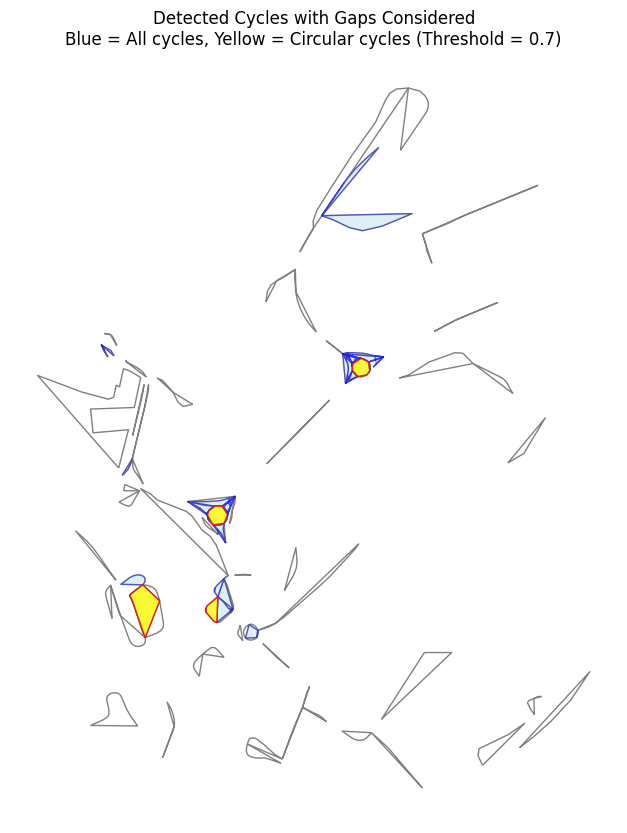

In [79]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib scipy --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
coords = [
    (21.58187,57.39391),
(21.59709, 57.39349),
(21.59732, 57.38221),
(21.58214,57.3824)
]
selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Fix invalid geometries ---
invalid_count = filtered_gdf[~filtered_gdf.is_valid].shape[0]
if invalid_count > 0:
    filtered_gdf['geometry'] = filtered_gdf['geometry'].buffer(0)

# --- Extract edges from each polygon ---
edges = []

def extract_edges(geom):
    polygons = [geom] if geom.geom_type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        coords = list(poly.exterior.coords)
        edges.extend([LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)])
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges.extend([LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords) - 1)])

for geom in filtered_gdf.geometry:
    extract_edges(geom)

# --- Build graph with proximity-based linking ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

SNAP_DISTANCE = 0.0001  # Adjust based on your data scale (~10m in degrees)

# Step 1: Collect endpoints and build KDTree
endpoints = []
edge_map = []

for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    endpoints.append(start)
    endpoints.append(end)
    edge_map.append((start, end, edge))

unique_points = list(set(endpoints))
point_array = np.array(unique_points)
tree = cKDTree(point_array)

# Step 2: Proximity pairs
pairs = tree.query_pairs(SNAP_DISTANCE)

# Step 3: Build graph
G = nx.Graph()

# Original edges
for start, end, edge in edge_map:
    G.add_edge(start, end, geometry=edge)

# Extra proximity edges
for i, j in pairs:
    pt1 = tuple(point_array[i])
    pt2 = tuple(point_array[j])
    if not G.has_edge(pt1, pt2):
        G.add_edge(pt1, pt2, geometry=LineString([pt1, pt2]))

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged_edges = unary_union(edge_geoms)
cycles = list(polygonize(merged_edges))

# --- Remove cycles that are part of input polygons ---
input_polygons = []
for geom in filtered_gdf.geometry:
    if geom.geom_type == "Polygon":
        input_polygons.append(geom)
    elif geom.geom_type == "MultiPolygon":
        input_polygons.extend(geom.geoms)

# Keep only cycles that are not equal to or inside input polygons
new_cycles = []
for cycle in cycles:
    if not any(poly.contains(cycle) or poly.equals(cycle) for poly in input_polygons):
        new_cycles.append(cycle)

# --- Calculate circularity ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Circularity threshold logic ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

if circular_cycles.empty:
    print("No circular cycles found at threshold 0.7, lowering threshold to 0.5")
    CIRCULARITY_THRESHOLD = 0.5
    circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles (not input polygons): {len(cycle_gdf)}")
print(f"Circular ones (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))

cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)

if not circular_cycles.empty:
    circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)

plt.title(f"Detected Cycles with Gaps Considered\nBlue = All cycles, Yellow = Circular cycles (Threshold = {CIRCULARITY_THRESHOLD})")
plt.axis("off")
plt.show()

# --- Save results ---
circular_cycles.to_file("user_defined_circular_cycles_with_gaps6.geojson", driver="GeoJSON")


Filtered polygons: 847
Total new cycles (excluding polygon rings): 46
Circular cycles (circularity ≥ 0.7): 9


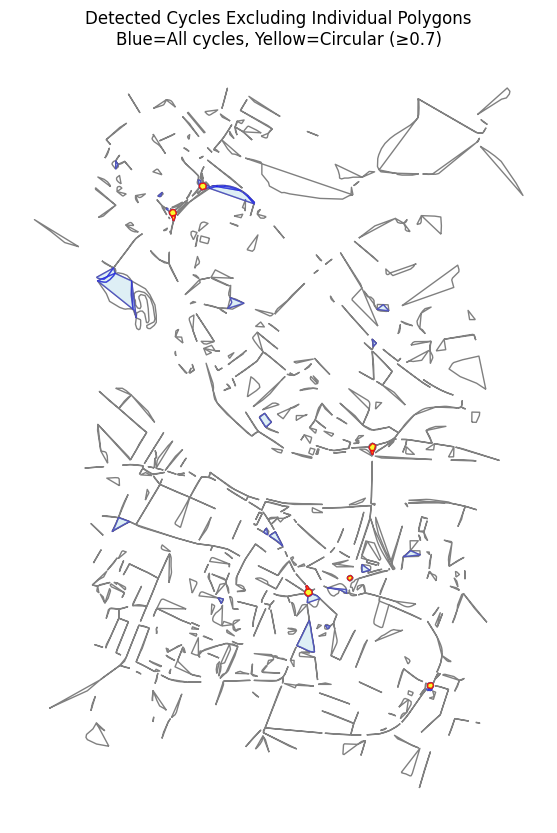

In [87]:
# --- Required Libraries ---
!pip install geopandas shapely fiona networkx matplotlib scipy --quiet

import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, LineString, Polygon, MultiPolygon, LinearRing
from shapely.ops import unary_union, polygonize
import fiona
import math
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np

# --- Load polygon shapefile ---
with fiona.open("polygon.shp") as src:
    large_geometries = [shape(feature["geometry"]) for feature in src]
    crs = src.crs

large_gdf = gpd.GeoDataFrame(geometry=large_geometries, crs=crs)

# --- Define selection polygon from coordinates (lon, lat) ---
#coords = [    (21.58187, 57.39391),    (21.59709, 57.39349),    (21.59732, 57.38221),    (21.58214, 57.3824)]

coords = [    (25.85121, 56.52142),    (25.89038, 56.52098),    (25.88738, 56.48394),    (25.84945, 56.48555)]

#coords = [    (27.262058, 57.135039),    (27.26764, 57.135047),    (27.267681, 57.131038),    (27.261936, 57.131054)]



selection_polygon = Polygon(coords)
selection_gdf = gpd.GeoDataFrame(geometry=[selection_polygon], crs=crs)

# --- Filter polygons intersecting the selection ---
selection_union = unary_union(selection_gdf.geometry)
filtered_gdf = large_gdf[large_gdf.geometry.intersects(selection_union)].reset_index(drop=True)
print(f"Filtered polygons: {len(filtered_gdf)}")

# --- Fix invalid geometries ---
invalid_count = filtered_gdf[~filtered_gdf.is_valid].shape[0]
if invalid_count > 0:
    filtered_gdf['geometry'] = filtered_gdf['geometry'].buffer(0)

# --- Extract edges from each polygon ---
edges = []

def extract_edges(geom):
    polygons = [geom] if geom.geom_type == 'Polygon' else list(geom.geoms)
    for poly in polygons:
        coords = list(poly.exterior.coords)
        edges.extend([LineString([coords[i], coords[i+1]]) for i in range(len(coords)-1)])
        for interior in poly.interiors:
            icoords = list(interior.coords)
            edges.extend([LineString([icoords[i], icoords[i+1]]) for i in range(len(icoords)-1)])

for geom in filtered_gdf.geometry:
    extract_edges(geom)

# --- Build graph with proximity-based linking ---
def round_coords(coord, precision=6):
    return (round(coord[0], precision), round(coord[1], precision))

SNAP_DISTANCE = 0.0001  # Adjust based on your data scale (~10m in degrees)

endpoints = []
edge_map = []

for edge in edges:
    coords = list(edge.coords)
    start = round_coords(coords[0])
    end = round_coords(coords[1])
    endpoints.append(start)
    endpoints.append(end)
    edge_map.append((start, end, edge))

unique_points = list(set(endpoints))
point_array = np.array(unique_points)
tree = cKDTree(point_array)

pairs = tree.query_pairs(SNAP_DISTANCE)

G = nx.Graph()

for start, end, edge in edge_map:
    G.add_edge(start, end, geometry=edge)

for i, j in pairs:
    pt1 = tuple(point_array[i])
    pt2 = tuple(point_array[j])
    if not G.has_edge(pt1, pt2):
        G.add_edge(pt1, pt2, geometry=LineString([pt1, pt2]))

# --- Detect cycles using polygonize ---
edge_geoms = list(nx.get_edge_attributes(G, 'geometry').values())
merged_edges = unary_union(edge_geoms)
cycles = list(polygonize(merged_edges))

# --- Collect all polygon rings from filtered polygons ---
input_rings = []

for geom in filtered_gdf.geometry:
    polygons = [geom] if geom.geom_type == "Polygon" else list(geom.geoms)
    for poly in polygons:
        input_rings.append(LinearRing(poly.exterior.coords))
        for interior in poly.interiors:
            input_rings.append(LinearRing(interior.coords))

# --- Function to check if a cycle matches any input polygon ring ---
# Use symmetric difference area with a small tolerance for floating precision

def is_similar_ring(cycle_poly, ring, tolerance_area=1e-8):
    # ring is LinearRing, convert to Polygon
    ring_poly = Polygon(ring)
    sym_diff_area = cycle_poly.symmetric_difference(ring_poly).area
    return sym_diff_area <= tolerance_area

def is_new_cycle(cycle, rings, tolerance_area=1e-8):
    for ring in rings:
        if is_similar_ring(cycle, ring, tolerance_area):
            return False
    return True

# Filter out cycles matching any polygon ring exactly or nearly
new_cycles = [c for c in cycles if is_new_cycle(c, input_rings)]

# --- Circularity calculation ---
def calculate_circularity(polygon):
    area = polygon.area
    perimeter = polygon.length
    return (4 * math.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

cycle_gdf = gpd.GeoDataFrame(geometry=new_cycles, crs=crs)
cycle_gdf["circularity"] = cycle_gdf.geometry.apply(calculate_circularity)

# --- Apply circularity threshold ---
CIRCULARITY_THRESHOLD = 0.7
circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

if circular_cycles.empty:
    print("No circular cycles found at threshold 0.7, lowering threshold to 0.5")
    CIRCULARITY_THRESHOLD = 0.5
    circular_cycles = cycle_gdf[cycle_gdf["circularity"] >= CIRCULARITY_THRESHOLD]

# --- Output ---
print(f"Total new cycles (excluding polygon rings): {len(cycle_gdf)}")
print(f"Circular cycles (circularity ≥ {CIRCULARITY_THRESHOLD}): {len(circular_cycles)}")

# --- Plot ---
base = filtered_gdf.plot(color="none", edgecolor="gray", figsize=(10, 10))
cycle_gdf.plot(ax=base, color="lightblue", edgecolor="blue", alpha=0.4)

if not circular_cycles.empty:
    circular_cycles.plot(ax=base, color="yellow", edgecolor="red", alpha=0.8)

plt.title(f"Detected Cycles Excluding Individual Polygons\nBlue=All cycles, Yellow=Circular (≥{CIRCULARITY_THRESHOLD})")
plt.axis("off")
plt.show()

# --- Save ---
circular_cycles.to_file("user_defined_circular_cycles_excluding_polygons.geojson", driver="GeoJSON")
